<a href="https://colab.research.google.com/github/aknakshay/VideoAnalytics/blob/master/Video_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Environment Preparation

In [0]:
#@title
%%capture

!pip install SpeechRecognition
!pip install mtcnn
#!sudo apt-get install -y build-essential swig
#!sudo pip install pocketsphinx
#!pip install moviepy
#!sudo apt-get install portaudio19-dev
#!sudo apt-get install python-pyaudio python3-pyaudio


### Face Alignment Code

In [0]:
#@title
%%capture

import numpy as np
import cv2


### https://www.pyimagesearch.com/2017/05/22/face-alignment-with-opencv-and-python/

class FaceAligner:
    def __init__(self, predictor, desiredLeftEye=(0.35, 0.35),
        desiredFaceWidth=224, desiredFaceHeight=224):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.predictor = predictor
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight

        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, image, keypoints):
        # convert the landmark (x, y)-coordinates to a NumPy array
        #shape = self.predictor(gray, rect)
        #shape = shape_to_np(shape)

        # extract the left and right eye (x, y)-coordinates
        #(lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
        #(rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]
        #leftEyePts = shape[lStart:lEnd]
        #rightEyePts = shape[rStart:rEnd]

        # compute the center of mass for each eye
        #leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
        #rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
        leftEyeCenter = keypoints['left_eye']
        rightEyeCenter = keypoints['right_eye']

        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) #- 180

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)

        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)
 
        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
 
        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])
        
        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
            flags=cv2.INTER_CUBIC)
 
        # return the aligned face
        return output

# Speech Analytics

##### Upload a video using the button below

In [3]:
from google.colab import files
uploaded = files.upload()
videoLocation = list(uploaded.keys())[0]

Saving videoplayback (1).mp4 to videoplayback (1).mp4


In [0]:
#@title
%%capture

from moviepy.editor import *
import speech_recognition as sr
from textblob import TextBlob
from skimage.util import montage
import matplotlib.pyplot as plt


In [0]:
#@title
%%capture

r = sr.Recognizer()
text = ""
video = VideoFileClip(videoLocation)
duration = video.duration
splitTime = 20

for i in range(0,int(duration),splitTime):
  try:
    if i + splitTime > duration:
      chunk = video.subclip(i,duration)
    else:
      chunk = video.subclip(i,i+splitTime)
    chunkAudio = chunk.audio
    chunkAudio.write_audiofile('tmp.wav')
    with sr.AudioFile('tmp.wav') as source:
      audio = r.record(source)  #
    text = text + " " +  r.recognize_google(audio)
  except Exception as e:
    print(e)


wiki = TextBlob(text)
sentimentPolarity = wiki.sentiment.polarity
setimentSubjectivity = wiki.sentiment.subjectivity



# Image Analytics

In [0]:
#@title
%%capture

import cv2
import numpy as np
import pandas as pd
from mtcnn.mtcnn import MTCNN


### Code for Extraction of Face from Image and Extraction of Image Frames from Video

In [0]:
#@title
%%capture

detector = MTCNN()
fa = FaceAligner(detector, desiredFaceWidth=48,desiredFaceHeight=48)

def preProcess(image):
  rects = detector.detect_faces(image)
  if len(rects) == 1  :
    faceAligned = fa.align(image, rects[0]['keypoints'])
    return 1,faceAligned
  else:
    return 0

def extractImages(pathIn):
    data = []
    count = 0
    vidcap = cv2.VideoCapture(pathIn)
    success,image = vidcap.read()
    success = True
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC,(count*2000))    # added this line 
        success,image = vidcap.read()
        try:
            status, image = preProcess(image)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray,(48,48))
        #print ('Read a new frame: ', success)
            data.append(resized)
        except Exception as e:
            print("Error")
        #cv2.imwrite( pathOut + "\\frame%d.jpg" % count, image)     # save frame as JPEG file
        count = count + 1
    ar = np.array(data)
    #ar = ar / 255
    return ar

In [0]:
#@title
%%capture
data = extractImages(videoLocation)

### Loading Model

In [0]:
#@title
%%capture

!wget https://github.com/aknakshay/VideoAnalytics/raw/master/emotion.h5

In [0]:
#@title
%%capture
import tensorflow as tf
model = tf.keras.models.load_model('emotion.h5')
l = list(data.shape)
l.append(-1)
results = model.predict(data.reshape(tuple(l)))
res = pd.DataFrame(results)
res.columns = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

In [0]:
#@title
emotionPerc = 100 * res.sum() / res.sum().sum()
emotionPerc = emotionPerc.apply(lambda x : round(x,2))
emotionPerc.sort_values(ascending=False,inplace=True)

# Result Summarisation

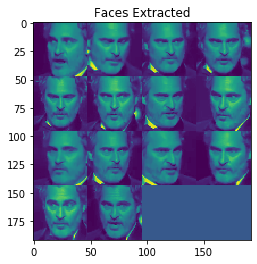

In [12]:
#@title
plt.imshow(montage(data, multichannel=False,rescale_intensity=True),interpolation='nearest')
plt.title("Faces Extracted");

In [13]:
#@title
print("Percentage of Emotions from extracted Faces: \n" + str(emotionPerc))

Percentage of Emotions from extracted Faces: 
Fear        42.62
Angry       32.46
Happy       20.31
Surprise     4.53
Neutral      0.07
Sad          0.00
Disgust      0.00
dtype: float64


In [18]:
#@title
import textwrap
bold_start = '\033[1m'
bold_end   = '\033[0m'

print(bold_start,"Text from Video:",bold_end)
print(textwrap.fill(text, 100))
print(bold_start,"\n\nSentiment Polarity: ",bold_end + str(round(sentimentPolarity,3)) + bold_start,"    Subjectivity: ", bold_end + str(round(setimentSubjectivity,3)))


print("\n\n Scale for Sentiment: -1 to 1 \n Scale for Subjectivity: 0 to 1")

 Text from Video: 
 I've been I've been a scoundrel in my life I've been selfish I've been cruel at times hard to work
with and ungrateful but so many of you in this room have given me a second chance and I think that's
when we're at our best when we support each other not when we cancel each other out for past
mistakes but when we help each other grow when we educate each other when we got each other towards
Redemption that is the best of humanity
 

Sentiment Polarity:  -0.013     Subjectivity:  0.444


 Scale for Sentiment: -1 to 1 
 Scale for Subjectivity: 0 to 1
